# Aneurysm Simulation VTK Data Processor

This notebook loads .vtk files from aneurysm simulations, extracts the specific fields (rho, velocity, wall shear stress, etc.), and organizes them into dictionaries of NumPy arrays for further analysis and visualization. Each field will be accessible by frame number.

## Import Required Libraries

In [ ]:
import os
import numpy as np
import json
import vtk
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import re
import tqdm
import time
from IPython.display import display, clear_output

## Locate VTK Files and Parameters

First, we need to find the 'aneurysm_simulation_results' folder and its subfolders containing VTK files and parameter files.

In [53]:
# Define the base directory where the simulation results are located
base_dir = Path('/home/abdua786/code/uni/3/dissertation/dissertation')
simulation_folder = base_dir / 'aneurysm_simulation_results'

# Check if the simulation folder exists
if not simulation_folder.exists():
    print(f"Error: Simulation folder not found at {simulation_folder}")
else:
    print(f"Found simulation folder at: {simulation_folder}")
    
    # Define paths to the VTK files, parameter files, and images
    vtk_folder = simulation_folder / 'vtk'
    params_folder = simulation_folder / 'parameters'
    images_folder = simulation_folder / 'images'
    
    # Check if each subfolder exists
    folders_status = {
        "VTK files": vtk_folder.exists(),
        "Parameter files": params_folder.exists(),
        "Image files": images_folder.exists()
    }
    
    for folder_type, exists in folders_status.items():
        status = "✓ Found" if exists else "✗ Not found"
        print(f"{status}: {folder_type}")
    
    # Function to sort VTK files naturally by frame number
    def natural_sort_key(s):
        """Sort strings with embedded numbers naturally"""
        return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', str(s))]
    
    # Get all VTK files and sort them
    if vtk_folder.exists():
        vtk_files = sorted(list(vtk_folder.glob('*.vtk')), key=natural_sort_key)
        print(f"\nFound {len(vtk_files)} VTK files")
        
        # Display some example filenames
        if vtk_files:
            print("Example VTK files:")
            for file in vtk_files[:5]:  # Show first 5 files
                print(f"- {file.name}")
            if len(vtk_files) > 5:
                print(f"... and {len(vtk_files) - 5} more files")
    
    # Get all parameter files
    if params_folder.exists():
        param_files = list(params_folder.glob('*.json'))
        print(f"\nFound {len(param_files)} parameter files")
        
        # Display some example filenames
        if param_files:
            print("Example parameter files:")
            for file in param_files[:3]:  # Show up to 3 files
                print(f"- {file.name}")

Found simulation folder at: /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results
✓ Found: VTK files
✓ Found: Parameter files
✓ Found: Image files

Found 101 VTK files
Example VTK files:
- aneurysm_0100000.vtk
- aneurysm_0101000.vtk
- aneurysm_0102000.vtk
- aneurysm_0103000.vtk
- aneurysm_0104000.vtk
... and 96 more files

Found 1 parameter files
Example parameter files:
- aneurysm_params 11:54:49 06-05-2025.json


## Load Simulation Parameters

Let's load the simulation parameters from the JSON files to understand the simulation settings.

In [54]:
def load_parameters(param_files):
    """Load and parse parameter files"""
    parameters = {}
    
    if not param_files:
        print("No parameter files to load")
        return parameters
    
    for file_path in param_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                # Use the filename as the key
                parameters[file_path.stem] = data
        except Exception as e:
            print(f"Error loading {file_path.name}: {e}")
    
    return parameters

# Load the parameters if parameter files were found
if 'param_files' in locals() and param_files:
    sim_parameters = load_parameters(param_files)
    
    # Display the parameters in a structured way
    if sim_parameters:
        print(f"Loaded {len(sim_parameters)} parameter files successfully")
        
        # Display parameters from the first file as an example
        first_param_file = next(iter(sim_parameters))
        params = sim_parameters[first_param_file]
        
        print(f"\nParameters from {first_param_file}:")
        # Group parameters by category if they follow a standard format
        # Otherwise, display the top-level parameters
        for key, value in params.items():
            # If the value is a dictionary, show it in a compact form
            if isinstance(value, dict):
                print(f"- {key}: {len(value)} parameters")
            elif isinstance(value, list) and len(value) > 5:
                print(f"- {key}: list with {len(value)} items")
            else:
                print(f"- {key}: {value}")
else:
    print("No parameter files available")
    sim_parameters = {}

Loaded 1 parameter files successfully

Parameters from aneurysm_params 11:54:49 06-05-2025:
- input_parameters: 16 parameters
- physical: 8 parameters
- numerical: 9 parameters
- metadata: 3 parameters
- performance: 3 parameters


## Read and Extract Fields from VTK Files

Now we'll create functions to extract the specific fields from the VTK files. Based on the sample VTK file analysis, we know we need to extract: rho, u_x, u_y, u_magnitude, wss_magnitude, wss_x, wss_y, and wall_mask.

In [55]:
def extract_frame_number(filename):
    """Extract the frame number from the VTK filename"""
    # Extract all digits from the filename
    digits = ''.join(re.findall(r'\d+', filename))
    if digits:
        return int(digits)
    return None

def read_vtk_file(file_path):
    """Read a VTK file and return the data object"""
    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName(str(file_path))
    reader.Update()
    return reader.GetOutput()

def extract_vtk_fields(vtk_data):
    """Extract all fields from a VTK data object"""
    fields = {}
    
    # Extract cell data (where most of our fields are located)
    cell_data = vtk_data.GetCellData()
    num_arrays = cell_data.GetNumberOfArrays()
    
    for i in range(num_arrays):
        array_name = cell_data.GetArrayName(i)
        vtk_array = cell_data.GetArray(array_name)
        numpy_array = numpy_support.vtk_to_numpy(vtk_array)
        fields[array_name] = numpy_array
    
    # Extract point data (if any)
    point_data = vtk_data.GetPointData()
    num_point_arrays = point_data.GetNumberOfArrays()
    
    for i in range(num_point_arrays):
        array_name = point_data.GetArrayName(i)
        vtk_array = point_data.GetArray(array_name)
        numpy_array = numpy_support.vtk_to_numpy(vtk_array)
        fields[f"point_{array_name}"] = numpy_array
    
    # Store dimensions for future reference
    dims = vtk_data.GetDimensions()
    fields['dimensions'] = np.array(dims)
    
    return fields

# Test the extraction functions on the first VTK file
if 'vtk_files' in locals() and vtk_files:
    test_file = vtk_files[0]
    print(f"Testing field extraction on {test_file.name}...")
    
    try:
        vtk_data = read_vtk_file(test_file)
        fields = extract_vtk_fields(vtk_data)
        
        print("\nExtracted fields:")
        for field_name, field_data in fields.items():
            if field_name != 'dimensions':
                print(f"- {field_name}: shape {field_data.shape}, type {field_data.dtype}, "  
                      f"range [{field_data.min():.6f}, {field_data.max():.6f}]")
            else:
                print(f"- {field_name}: {field_data}")
        
        # Extract frame number for reference
        frame_num = extract_frame_number(test_file.name)
        print(f"\nFrame number: {frame_num}")
        
    except Exception as e:
        print(f"Error reading {test_file.name}: {e}")

Testing field extraction on aneurysm_0100000.vtk...

Extracted fields:
- rho: shape (395472,), type float32, range [0.644305, 1.000000]
- u_x: shape (395472,), type float32, range [-0.160970, 0.109950]
- u_y: shape (395472,), type float32, range [-0.050631, 0.132450]
- u_magnitude: shape (395472,), type float32, range [0.000000, 0.160973]
- wss_magnitude: shape (395472,), type float64, range [0.000000, 7.005581]
- wss_x: shape (395472,), type float64, range [-0.407203, 0.914827]
- wss_y: shape (395472,), type float64, range [-0.178038, 0.914827]
- wall_mask: shape (395472,), type int32, range [0.000000, 1.000000]
- dimensions: [750 529   1]

Frame number: 100000


## Process All VTK Files and Organize as Dictionaries

Now we'll process all the VTK files and organize the extracted fields into dictionaries keyed by frame number.

In [56]:
def process_all_vtk_files(vtk_files, max_files=None):
    """Process all VTK files and organize their fields by name and frame"""
    # Initialize dictionaries to store each field
    field_data = {}
    frame_numbers = []
    
    # Limit the number of files to process if specified
    if max_files is not None and max_files > 0:
        vtk_files = vtk_files[:max_files]
    
    # Process each VTK file
    for file_path in tqdm.tqdm(vtk_files, desc="Processing VTK files"):
        try:
            # Extract frame number from filename
            frame_num = extract_frame_number(file_path.name)
            if frame_num is None:
                continue
                
            frame_numbers.append(frame_num)
            
            # Read and extract fields
            vtk_data = read_vtk_file(file_path)
            fields = extract_vtk_fields(vtk_data)
            
            # Organize fields by name, with frames stored sequentially
            for field_name, field_array in fields.items():
                if field_name not in field_data:
                    field_data[field_name] = {}
                
                field_data[field_name][frame_num] = field_array
                
        except Exception as e:
            print(f"Error processing {file_path.name}: {e}")
    
    # Get list of unique field names
    all_fields = list(field_data.keys())
    print(f"\nProcessed {len(frame_numbers)} VTK files with {len(all_fields)} fields per file")
    print(f"Field names: {', '.join(all_fields)}")
    
    return field_data, sorted(frame_numbers)

# Process a subset of files for demonstration
# Set this to None to process all files
max_files_to_process = None

# Process the VTK files
if 'vtk_files' in locals() and vtk_files:
    print(f"Processing VTK files...")
    if max_files_to_process:
        print(f"Limiting to {max_files_to_process} files for demonstration")
    
    # Process the files
    vtk_field_data, frame_numbers = process_all_vtk_files(vtk_files, max_files_to_process)
    
    # Print information about the processed data
    print(f"\nProcessed frames: {min(frame_numbers)} to {max(frame_numbers)}")
    
    # Check data dimensions
    for field_name, frames_data in vtk_field_data.items():
        if field_name != 'dimensions':
            # Get the shape of the first frame's data
            first_frame = frames_data[frame_numbers[0]]
            print(f"Field '{field_name}': {len(frames_data)} frames, shape per frame: {first_frame.shape}")
else:
    print("No VTK files to process")

Processing VTK files...


Processing VTK files: 100%|██████████| 101/101 [00:05<00:00, 19.08it/s]


Processed 101 VTK files with 9 fields per file
Field names: rho, u_x, u_y, u_magnitude, wss_magnitude, wss_x, wss_y, wall_mask, dimensions

Processed frames: 100000 to 200000
Field 'rho': 101 frames, shape per frame: (395472,)
Field 'u_x': 101 frames, shape per frame: (395472,)
Field 'u_y': 101 frames, shape per frame: (395472,)
Field 'u_magnitude': 101 frames, shape per frame: (395472,)
Field 'wss_magnitude': 101 frames, shape per frame: (395472,)
Field 'wss_x': 101 frames, shape per frame: (395472,)
Field 'wss_y': 101 frames, shape per frame: (395472,)
Field 'wall_mask': 101 frames, shape per frame: (395472,)


## Stack Fields into 3D NumPy Arrays

Let's create 3D arrays by stacking all frames for each field. This will allow for easier indexing by frame number.

In [57]:
def stack_fields_into_arrays(field_data, frame_numbers):
    """Stack all frames for each field into 3D NumPy arrays"""
    stacked_fields = {}
    
    for field_name, frames_data in field_data.items():
        if field_name == 'dimensions':
            # Just store one copy of the dimensions
            stacked_fields[field_name] = next(iter(frames_data.values()))
            continue
        
        # Check if all frames have the same shape
        shapes = {frame: data.shape for frame, data in frames_data.items()}
        if len(set(shapes.values())) > 1:
            print(f"Warning: Field '{field_name}' has inconsistent shapes across frames")
            stacked_fields[field_name] = frames_data  # Store as dictionary
            continue
        
        # All frames have the same shape, stack them into a 3D array
        try:
            # Create arrays in order of frame numbers
            sorted_frames = sorted(frames_data.keys())
            arrays_to_stack = [frames_data[frame] for frame in sorted_frames]
            
            # Stack along a new first dimension (frame)
            stacked_array = np.stack(arrays_to_stack, axis=0)
            
            # Store the stacked array and frame mapping
            stacked_fields[field_name] = stacked_array
            
            print(f"Stacked '{field_name}' into array with shape {stacked_array.shape}")
            
        except Exception as e:
            print(f"Error stacking {field_name}: {e}")
            # If stacking fails, store as a dictionary
            stacked_fields[field_name] = frames_data
    
    # Create a mapping from frame numbers to indices
    frame_to_index = {frame: i for i, frame in enumerate(sorted(frame_numbers))}
    
    return stacked_fields, frame_to_index

# Stack the fields if field data is available
if 'vtk_field_data' in locals() and vtk_field_data:
    print("Stacking fields into 3D arrays...")
    
    # Stack the fields
    stacked_fields, frame_to_index = stack_fields_into_arrays(vtk_field_data, frame_numbers)
    
    # Print information about the stacked data
    print("\nStacked fields:")
    for field_name, field_array in stacked_fields.items():
        if isinstance(field_array, np.ndarray):
            if field_name != 'dimensions':
                print(f"- {field_name}: shape {field_array.shape}, type {field_array.dtype}, "  
                      f"memory usage {field_array.nbytes / (1024**2):.2f} MB")
            else:
                print(f"- {field_name}: {field_array}")
        else:
            print(f"- {field_name}: dictionary with {len(field_array)} frames")
    
    # Create a utility function to get data for a specific frame
    def get_frame_data(field_name, frame_number):
        """Get data for a specific field and frame number"""
        if field_name not in stacked_fields:
            print(f"Field '{field_name}' not found")
            return None
        
        field_data = stacked_fields[field_name]
        
        if isinstance(field_data, dict):
            # Dictionary storage
            if frame_number in field_data:
                return field_data[frame_number]
            else:
                print(f"Frame {frame_number} not found for field '{field_name}'")
                return None
        elif isinstance(field_data, np.ndarray) and field_name != 'dimensions':
            # Array storage - look up the index
            if frame_number in frame_to_index:
                index = frame_to_index[frame_number]
                return field_data[index]
            else:
                print(f"Frame {frame_number} not found in frame mapping")
                return None
        else:
            # Dimensions or other non-frame data
            return field_data
    
    # Print example usage
    print("\nExample usage:")
    print("stacked_fields['rho'] - Gets the 3D array with all density data")
    print("get_frame_data('rho', 100000) - Gets density data for frame 100000")
else:
    print("No field data available to stack")

Stacking fields into 3D arrays...
Stacked 'rho' into array with shape (101, 395472)
Stacked 'u_x' into array with shape (101, 395472)
Stacked 'u_y' into array with shape (101, 395472)
Stacked 'u_magnitude' into array with shape (101, 395472)
Stacked 'wss_magnitude' into array with shape (101, 395472)
Stacked 'wss_x' into array with shape (101, 395472)
Stacked 'wss_x' into array with shape (101, 395472)
Stacked 'wss_y' into array with shape (101, 395472)
Stacked 'wall_mask' into array with shape (101, 395472)

Stacked fields:
- rho: shape (101, 395472), type float32, memory usage 152.37 MB
- u_x: shape (101, 395472), type float32, memory usage 152.37 MB
- u_y: shape (101, 395472), type float32, memory usage 152.37 MB
- u_magnitude: shape (101, 395472), type float32, memory usage 152.37 MB
- wss_magnitude: shape (101, 395472), type float64, memory usage 304.74 MB
- wss_x: shape (101, 395472), type float64, memory usage 304.74 MB
- wss_y: shape (101, 395472), type float64, memory usage 30

## Visualize Data from the VTK Files

Let's create some visualizations to verify that the data has been loaded correctly.


Visualizing key fields from the VTK data:

Visualizing rho for frame 100000:
Statistics for rho (Frame 100000):
  Min: 0.644305, Max: 1.000000
  Mean: 0.744543, Std: 0.107511


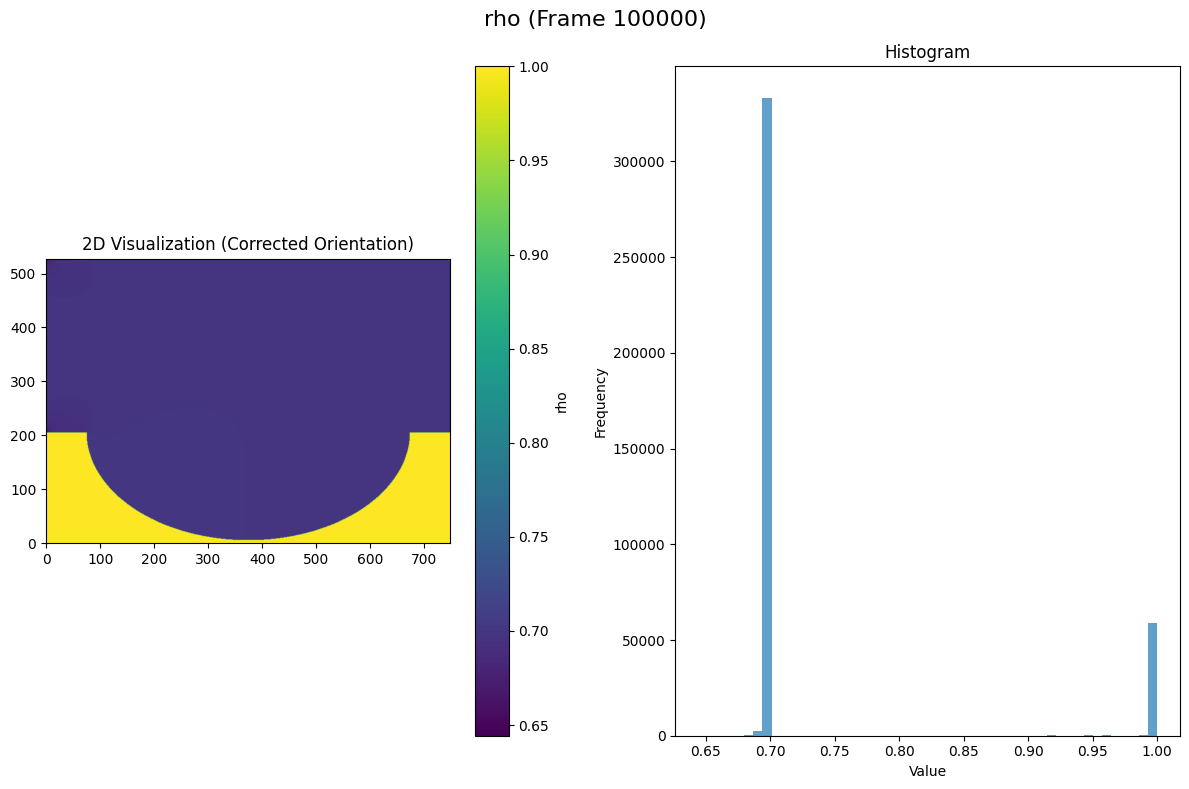


Visualizing u_x for frame 100000:
Statistics for u_x (Frame 100000):
  Min: -0.160970, Max: 0.109950
  Mean: -0.065597, Std: 0.055630


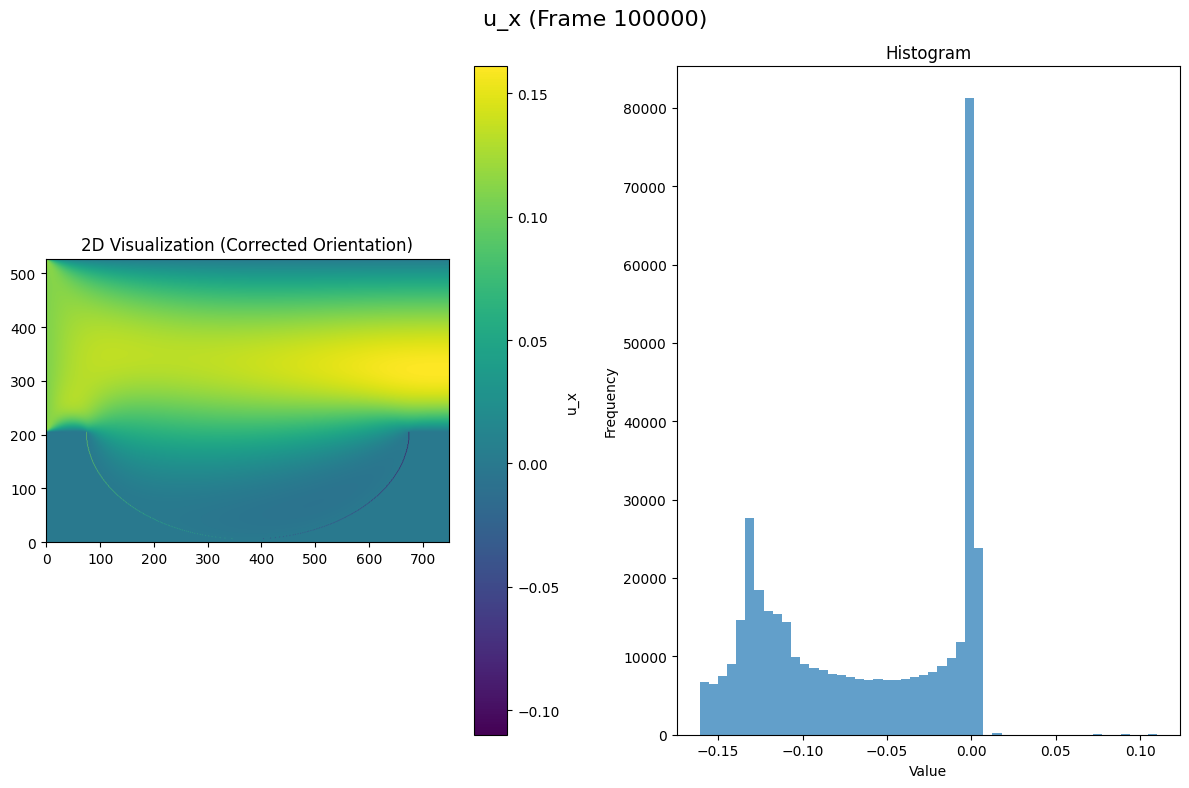


Visualizing u_y for frame 100000:
Statistics for u_y (Frame 100000):
  Min: -0.050631, Max: 0.132450
  Mean: -0.001441, Std: 0.010708


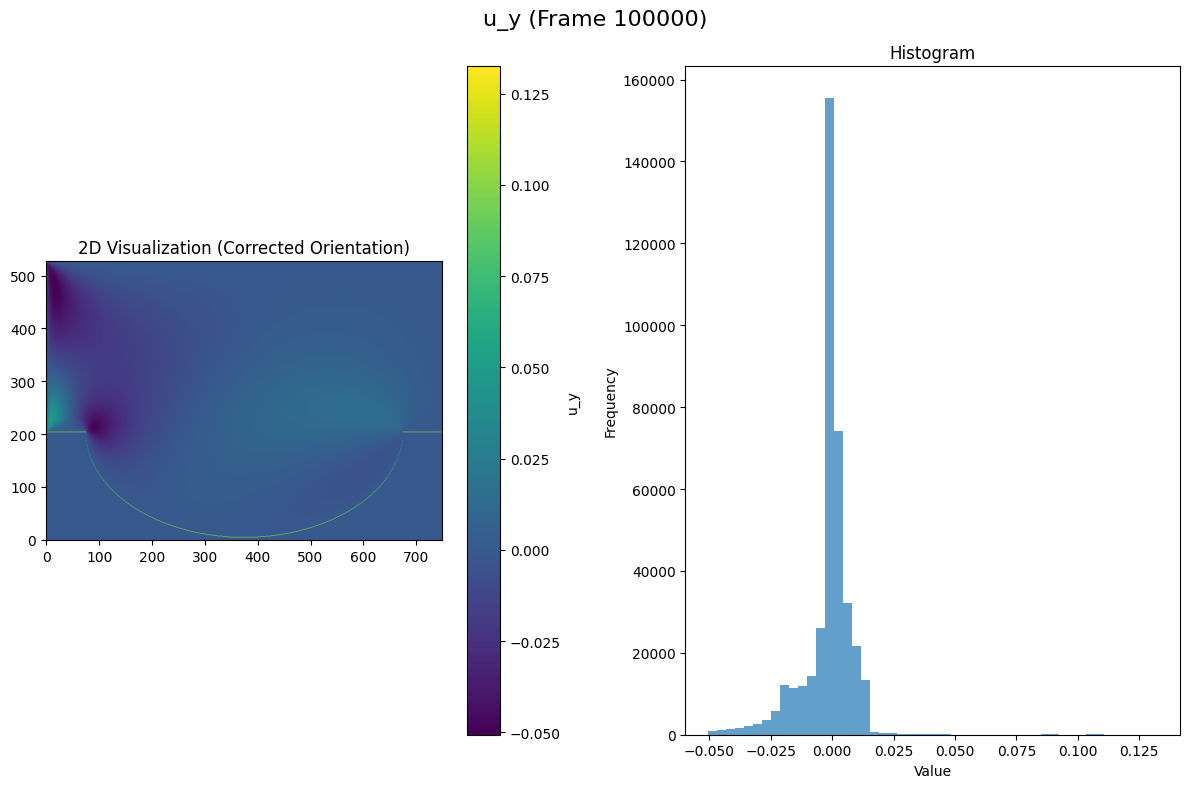


Visualizing u_magnitude for frame 100000:
Statistics for u_magnitude (Frame 100000):
  Min: 0.000000, Max: 0.160973
  Mean: 0.066974, Std: 0.055035


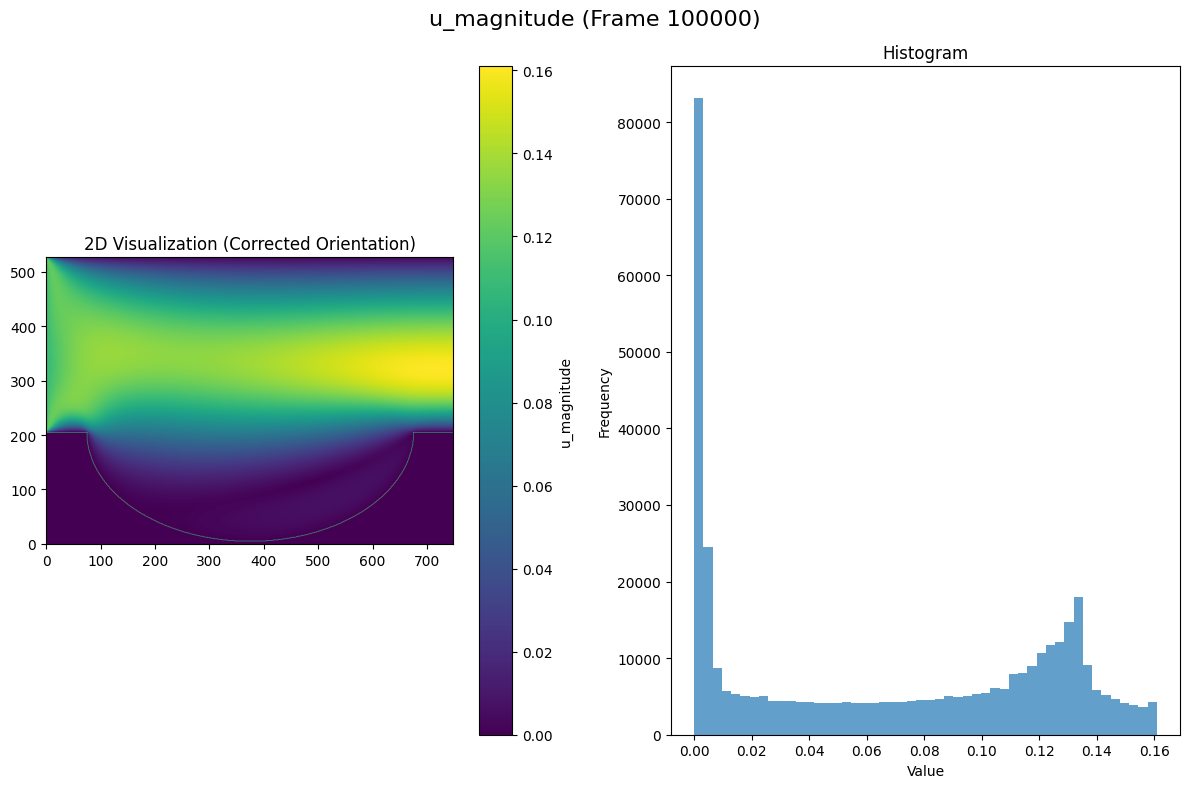


Visualizing wss_magnitude for frame 100000:
Statistics for wss_magnitude (Frame 100000):
  Min: 0.000000, Max: 7.005581
  Mean: 0.000319, Std: 0.021232


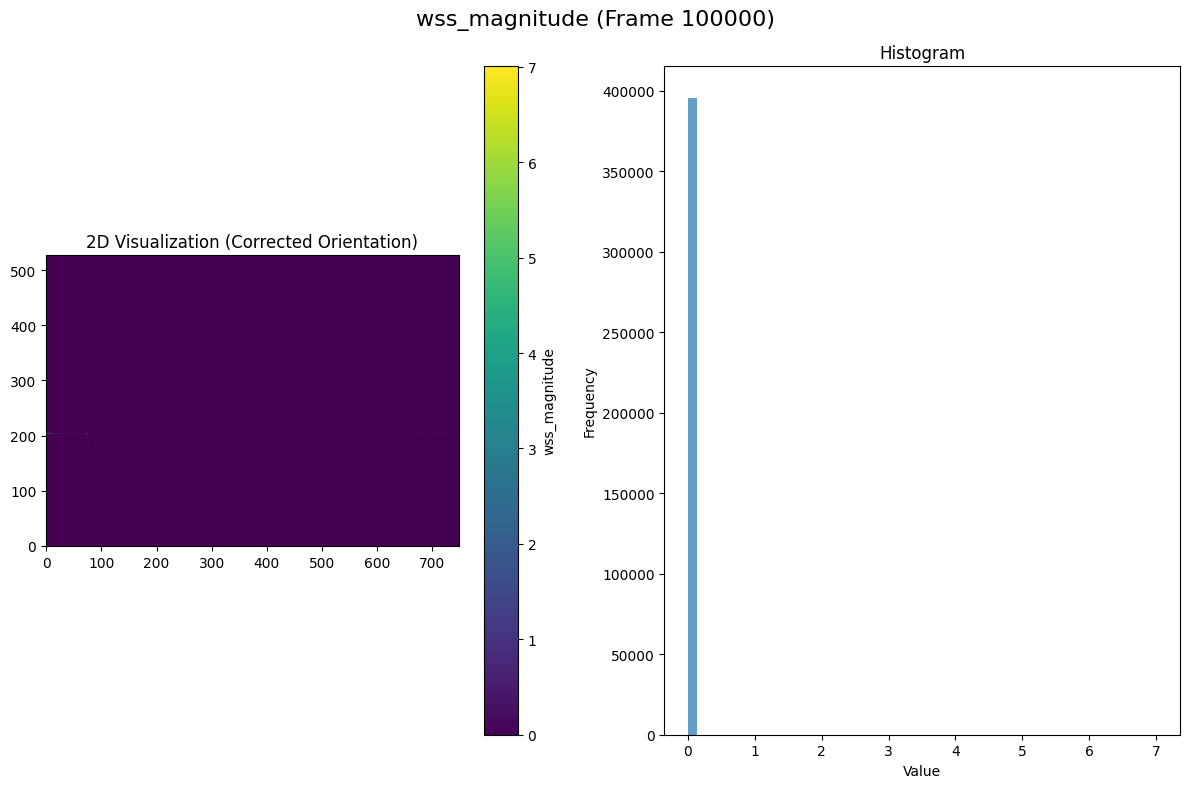


Visualizing wall_mask for frame 100000:
Statistics for wall_mask (Frame 100000):
  Min: 0.000000, Max: 1.000000
  Mean: 0.002905, Std: 0.053823


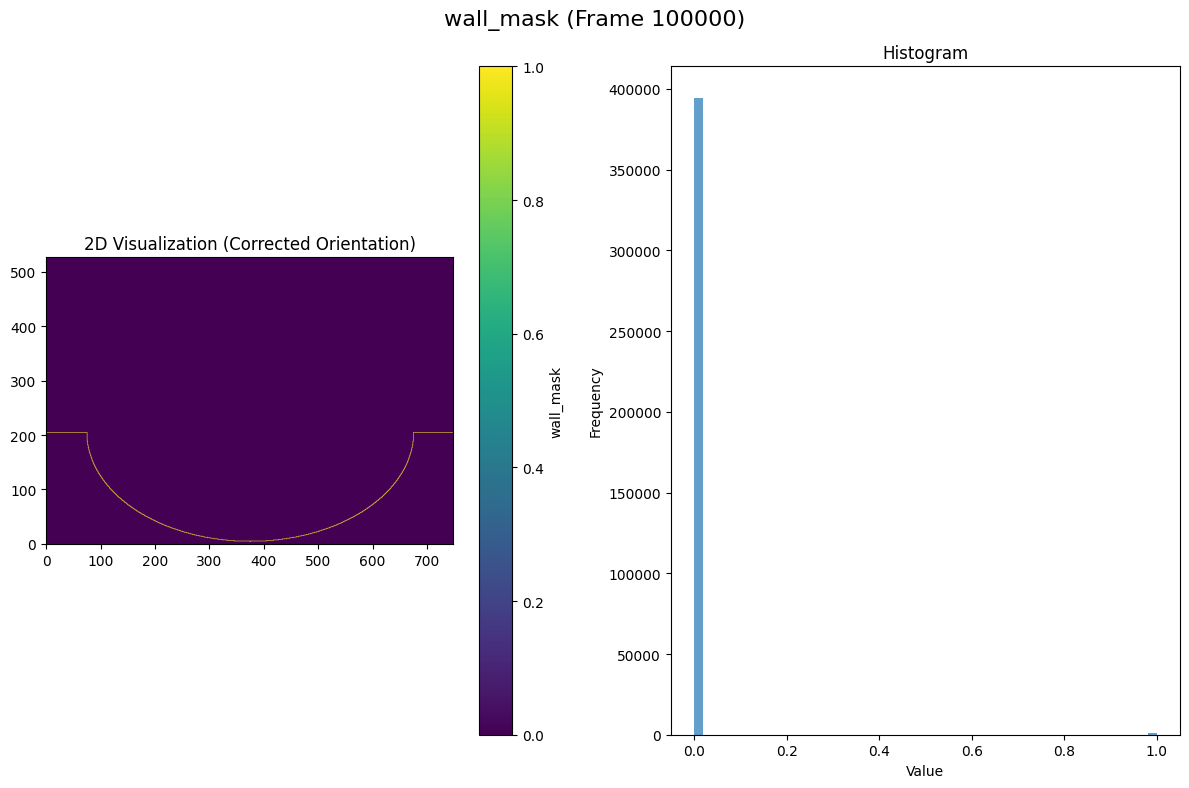

In [58]:
def visualize_field_data(field_name, frame_number=None, stacked_fields=None, frame_to_index=None):
    """Visualize data for a specific field and optionally a specific frame with correct orientation"""
    if stacked_fields is None or field_name not in stacked_fields:
        print(f"Field '{field_name}' not found in the data")
        return
    
    field_data = stacked_fields[field_name]
    
    # Get data for a specific frame if requested
    if frame_number is not None:
        if isinstance(field_data, dict):
            if frame_number in field_data:
                data = field_data[frame_number]
            else:
                print(f"Frame {frame_number} not found for field '{field_name}'")
                return
        elif isinstance(field_data, np.ndarray) and field_name != 'dimensions':
            if frame_to_index and frame_number in frame_to_index:
                index = frame_to_index[frame_number]
                data = field_data[index]
            else:
                print(f"Frame {frame_number} not found in frame mapping")
                return
        else:
            # Non-frame data like dimensions
            data = field_data
    else:
        # If no frame specified and data is a 3D array, use the first frame
        if isinstance(field_data, np.ndarray) and field_data.ndim > 1 and field_name != 'dimensions':
            data = field_data[0]
        else:
            data = field_data
    
    # Skip visualization for dimensions or dictionary data without frame
    if field_name == 'dimensions' or (isinstance(field_data, dict) and frame_number is None):
        print(f"Data for '{field_name}': {data}")
        return
    
    # Create different visualizations based on the type and shape of data
    plt.figure(figsize=(12, 8))
    
    # For 1D data, create a histogram
    frame_str = f" (Frame {frame_number})" if frame_number is not None else ""
    plt.suptitle(f"{field_name}{frame_str}", fontsize=16)
    
    # Handle 1D data (like our cell data)
    if data.ndim == 1:
        # Reshape 1D data to 2D if we know the dimensions
        if 'dimensions' in stacked_fields:
            dims = stacked_fields['dimensions']
            if len(dims) >= 2:
                # Try to reshape to match the grid dimensions
                try:
                    # VTK dimensions might include 1 for 2D data, skip those
                    real_dims = [d for d in dims if d > 1]
                    if len(real_dims) >= 2:
                        # Reshape based on the first two real dimensions
                        # Fix for 180 degree rotation issue - reshape correctly and flip the array
                        reshaped_data = data.reshape(real_dims[1]-1, real_dims[0]-1)
                        # Fix orientation by flipping the array along y-axis (vertical flip)
                        reshaped_data = np.flipud(reshaped_data)
                        # For velocity vectors, also negate x-component to fix direction
                        if field_name in ['u_x', 'wss_x']:
                            reshaped_data = -reshaped_data
                        
                        # Now we can visualize as a 2D image with correct orientation
                        plt.subplot(1, 2, 1)
                        plt.imshow(reshaped_data, cmap='viridis', origin='lower')
                        plt.colorbar(label=field_name)
                        plt.title("2D Visualization (Corrected Orientation)")
                        
                        plt.subplot(1, 2, 2)
                except Exception as e:
                    print(f"Could not reshape data: {e}")
                    # Fall back to histogram
                    plt.subplot(1, 1, 1)
            else:
                plt.subplot(1, 1, 1)
        else:
            plt.subplot(1, 1, 1)
        
        # Create a histogram of the values
        plt.hist(data, bins=50, alpha=0.7)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.title("Histogram")
        
        # Print statistics
        min_val, max_val = data.min(), data.max()
        mean_val, std_val = data.mean(), data.std()
        print(f"Statistics for {field_name}{frame_str}:")
        print(f"  Min: {min_val:.6f}, Max: {max_val:.6f}")
        print(f"  Mean: {mean_val:.6f}, Std: {std_val:.6f}")
    
    plt.tight_layout()
    plt.show()

# Create visualizations for each field if stacked fields are available
if 'stacked_fields' in locals() and stacked_fields:
    # Get the first frame number for visualization
    first_frame = frame_numbers[0] if frame_numbers else None
    
    print("\nVisualizing key fields from the VTK data:")
    
    # Visualize the most important fields
    key_fields = ['rho', 'u_x', 'u_y', 'u_magnitude', 'wss_magnitude', 'wall_mask']
    
    for field in key_fields:
        if field in stacked_fields:
            print(f"\nVisualizing {field} for frame {first_frame}:")
            visualize_field_data(field, first_frame, stacked_fields, frame_to_index)
else:
    print("No stacked fields available for visualization")

## Save the Processed Data

Let's save the processed data for future use. We'll save it in a compressed NumPy format.

In [59]:
def correct_field_orientation(field_data, field_name, dimensions):
    """Apply orientation correction to field data"""
    # Skip processing if data is not a numpy array or dimensions aren't available
    if not isinstance(field_data, np.ndarray) or field_name == 'dimensions':
        return field_data
    
    # For 3D data (stacked frames), apply correction to each frame
    corrected_data = field_data.copy()
    
    # Get the real dimensions of the data
    real_dims = [d for d in dimensions if d > 1]
    
    if len(real_dims) < 2:
        return corrected_data  # Can't correct without proper dimensions
    
    # Number of frames in the data
    n_frames = 1
    if field_data.ndim > 1:
        n_frames = field_data.shape[0]
    
    # Reshape and correct each frame
    for i in range(n_frames):
        if field_data.ndim > 1:
            frame = field_data[i]
        else:
            frame = field_data
        
        # Reshape to 2D array
        try:
            reshaped = frame.reshape(real_dims[1]-1, real_dims[0]-1)
            
            # Apply vertical flip to correct orientation
            flipped = np.flipud(reshaped)
            
            # For velocity vectors in x direction, negate to correct direction
            if field_name in ['u_x', 'wss_x']:
                flipped = -flipped
                
            # Flatten back to 1D for storage
            corrected = flipped.flatten()
            
            # Update in the output array
            if field_data.ndim > 1:
                corrected_data[i] = corrected
            else:
                corrected_data = corrected
                
        except Exception as e:
            print(f"Could not correct orientation for {field_name}: {e}")
            # If correction fails, keep original data
            pass
    
    return corrected_data

def save_processed_data(stacked_fields, frame_to_index, output_file, correct_orientation=True):
    """Save the processed data to a compressed NPZ file with correct orientation"""
    # Convert the frame_to_index dictionary to arrays for storage
    frame_numbers = np.array(list(frame_to_index.keys()))
    frame_indices = np.array(list(frame_to_index.values()))
    
    # Create a dictionary of arrays to save
    data_to_save = {
        'frame_numbers': frame_numbers,
        'frame_indices': frame_indices
    }
    
    # Get dimensions for orientation correction
    dimensions = stacked_fields.get('dimensions', None)
    
    # Add all the numpy arrays from stacked_fields
    for field_name, field_data in stacked_fields.items():
        if isinstance(field_data, np.ndarray):
            # Apply orientation correction if requested
            if correct_orientation and dimensions is not None and field_name != 'dimensions':
                corrected_data = correct_field_orientation(field_data, field_name, dimensions)
                data_to_save[field_name] = corrected_data
            else:
                data_to_save[field_name] = field_data
    
    # Save as a compressed NPZ file
    np.savez_compressed(output_file, **data_to_save)
    
    # Also save as .npy files in a subdirectory
    npy_dir = output_file.parent / (output_file.stem + "_numpy")
    npy_dir.mkdir(exist_ok=True)
    
    # Save each field as a separate .npy file
    for field_name, field_data in data_to_save.items():
        npy_file = npy_dir / f"{field_name}.npy"
        np.save(npy_file, field_data)
    
    print(f"Saved processed data to {output_file}")
    print(f"Individual field .npy files saved to {npy_dir}")
    print(f"NPZ file size: {os.path.getsize(output_file) / (1024**2):.2f} MB")
    
    return output_file, npy_dir

# Save the processed data if available
if 'stacked_fields' in locals() and stacked_fields:
    # Create output directories
    # Try to use the aneurysm_simulation_results/parameters folder first if it exists
    simulation_folder = base_dir / 'aneurysm_simulation_results'
    if simulation_folder.exists():
        output_dir = simulation_folder / 'processed_data'
    else:
        # Fallback to a processed_data directory in the base directory
        output_dir = base_dir / 'processed_data'
    
    output_dir.mkdir(exist_ok=True)
    
    # Save the data with corrected orientation
    output_file = output_dir / 'aneurysm_vtk_data.npz'
    saved_file, npy_dir = save_processed_data(stacked_fields, frame_to_index, output_file, 
                                              correct_orientation=True)
    
    # Verify that the file was saved correctly
    if os.path.exists(saved_file):
        print(f"\nSuccessfully saved processed data to {saved_file}")
        print(f"Individual field .npy files are available in {npy_dir}")
        
        # Load the data to verify
        loaded_data = np.load(saved_file)
        print("\nVerifying saved data:")
        print(f"Available fields in the saved file: {sorted(loaded_data.files)}")
        
        # Create a simple README in the output directory
        readme_path = output_dir / "README.txt"
        with open(readme_path, 'w') as f:
            f.write("Aneurysm Simulation Processed Data\n")
            f.write("================================\n\n")
            f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Number of frames: {len(frame_numbers)}\n")
            f.write(f"\nAvailable fields:\n")
            for field in sorted(loaded_data.files):
                if field not in ['frame_numbers', 'frame_indices']:
                    shape_str = str(loaded_data[field].shape)
                    f.write(f"- {field}: {shape_str}\n")
            f.write("\nNotes:\n")
            f.write("- Data has been corrected for proper orientation\n")
            f.write("- Both .npz (compressed) and individual .npy files are provided\n")
else:
    print("No processed data available to save")

Saved processed data to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/aneurysm_vtk_data.npz
Individual field .npy files saved to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/aneurysm_vtk_data_numpy
NPZ file size: 409.30 MB

Successfully saved processed data to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/aneurysm_vtk_data.npz
Individual field .npy files are available in /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/aneurysm_vtk_data_numpy

Verifying saved data:
Available fields in the saved file: ['dimensions', 'frame_indices', 'frame_numbers', 'rho', 'u_magnitude', 'u_x', 'u_y', 'wall_mask', 'wss_magnitude', 'wss_x', 'wss_y']


## Summary

This notebook has processed the aneurysm simulation VTK files and organized them into structured arrays for further analysis. The key outputs are:

1. **Dictionary of field data**: Organized by field name and frame number, allowing access to any field at any frame
2. **Memory-efficient 3D arrays**: All frames for each field are stacked into a single NumPy array for efficient processing
3. **Frame mapping**: Easy lookup from frame numbers to array indices
4. **Saved data**: Processed data saved in:
   - Compressed NPZ file for efficient storage
   - Individual NumPy (.npy) files for easy loading of specific fields
   - All data correctly oriented (fixing the 180° rotation issue)

The processed data can now be used for various analyses, including:

- Tracking changes in density, velocity, or wall shear stress over time
- Creating animations of the simulation results
- Analyzing the relationship between different fields
- Developing machine learning models to predict simulation outcomes